<a href="https://colab.research.google.com/github/emzu/MARISA_IDF/blob/main/MARISA_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lmoments3 #L-moments Package to fit distributions
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 689.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.3 MB/s eta 0:00:00


In [ ]:
import xarray as xr  # Library for working with labeled multi-dimensional arrays
import numpy as np  # Library for numerical computations
import matplotlib.pyplot as plt  # Library for plotting
import glob  # Library for file handling (not used in this snippet)
import requests  # Library for making HTTP requests (used to fetch data)
import os  # Library for interacting with the operating system
import pandas as pd
import pickle # Library for saving python objects
import seaborn as sns
import lmoments3 as lm
from lmoments3 import distr
from scipy.stats import genextreme

In [ ]:
import os
!apt-get install wget -q # Install wget

Reading package lists...
Building dependency tree...
Reading state information...
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
def array_mean(series):
    return series.values.mean()

def calc_rp_values(data, type = 'empirical'):
  """
  Calculates return period values for precipitation data.

  Args:
    data: A pandas Series containing DAILY precipitation values.

  Returns:
    A pandas DataFrame containing return period values for durations and return periods.
  """

  #Check Data Format, make Pandas Series
  if isinstance(data, np.ndarray):
    data = pd.Series(data)

  return_periods = [2, 5, 10, 25, 50, 100]
  duration = ['24-hr', '2-day', '3-day', '4-day', '7-day', '10-day',
       '20-day', '30-day', '45-day', '60-day']

  #Initialize DataFrame to return threshold values
  loca_thresholds_cp = pd.DataFrame(columns=return_periods, index=duration)
  num_years = int(data.size/365)

  for d in duration:
    if d.split('-')[1]=='day':
      window_length = int(d.split('-')[0])
    elif d.split('-')[1]=='hr':
      window_length = int(int(d.split('-')[0])/24)
    r_sum = data.rolling(window=window_length).sum()
    #Sort values largest to smallest
    r_sum = r_sum.sort_values(ascending=False, na_position='last')

    for rp in return_periods:
      n_days = rp * 365.25  # Convert return period in years to number of days
      exceedance_prob = 365.25 / n_days  # Probability of exceeding this threshold in a given year
      if type == 'empirical':
        # Compute threshold using percentile (inverse of exceedance probability) using first n-values of precipitation given n-year long record
        threshold = np.percentile(r_sum[:num_years], 100 - (exceedance_prob * 100))
      elif type == 'lmom':
        #Compute threshold according to L-moments fitted GEV distribution
        fit_paras = distr.gev.lmom_fit(r_sum[:num_years].fillna(0).values) #Fit the distribution to the data
        fitted_gev = distr.gev(**fit_paras)
        threshold = fitted_gev.ppf(1 - exceedance_prob)
        ## Check distribution fit
      elif type == 'mle':
        #Compute threshold according to MLE fitted GEV distribution
        fit_paras_mle = genextreme.fit(r_sum[:num_years].fillna(0).values) #Fit the distribution to the data
        threshold = genextreme.ppf(1 - exceedance_prob, *fit_paras_mle)
      # Store the computed threshold
      loca_thresholds_cp.loc[d,rp] = threshold

  return loca_thresholds_cp

In [ ]:
def processDS_Precip(ds, locs):
  #Daily (24-hr) Precipitation
  precip = ds['pr']

  #Slice xr for station location
  precip = precip.sel(
      lon=locs[0],
      lat=locs[1],
      method='nearest'
  )
  # Convert precipitation from kg m⁻² s⁻¹ to inches per day:
  precip = np.array(precip*86400*0.0393701)
  # Replace negative values with NaN (negative values indicate missing data)
  precip[precip<0.] = np.nan

  return precip

def annual_totals(precip):
  daily_data = pd.Series(precip, index=pd.date_range('1950-01-01', periods=len(precip)))

  annual_totals = daily_data.resample('YE').sum()
  return annual_totals


In [ ]:
# =============================================================================
# IDF Curves using Atlas 14
# =============================================================================

atlas14 = pd.read_csv('/content/drive/MyDrive/Research/MARISA_IDF/pgh_atlas14.csv', index_col=[0])

# =============================================================================
# Precipitation Observations
# =============================================================================
precip_obs = pd.read_csv('/content/drive/MyDrive/Research/MARISA_IDF/PIT_precip_hist1945_2025.csv', index_col=[0])
obs_thresholds_lmom = calc_rp_values(precip_obs['PRCP'], type = 'lmom')
obs_thresholds_mle = calc_rp_values(precip_obs['PRCP'], type = 'mle')
obs_thresholds_empirical = calc_rp_values(precip_obs['PRCP'], type = 'empirical')

#annual_totals_obs = precip_obs.resample('Y').sum()

<ipython-input-56-6bdf8dc2aa14>:15: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_totals_obs = precip_obs.resample('Y').sum()


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [ ]:

# =============================================================================
# LOCA
# =============================================================================

# List of climate models used in the LOCA dataset. These models provide historical
# and future climate projections downscaled to a high resolution.
models = [
    "ACCESS1-0","ACCESS1-3","CCSM4","CESM1-BGC","CESM1-CAM5","CMCC-CM","CMCC-CMS",
    "CNRM-CM5","CSIRO-Mk3-6-0","CanESM2","EC-EARTH","FGOALS-g2","GFDL-CM3",
    "GFDL-ESM2G","GFDL-ESM2M","GISS-E2-R","HadGEM2-AO","HadGEM2-CC","HadGEM2-ES",
    "IPSL-CM5A-LR","IPSL-CM5A-MR","MIROC-ESM","MIROC-ESM-CHEM","MIROC5",
    "MPI-ESM-LR","MPI-ESM-MR","MRI-CGCM3","NorESM1-M","bcc-csm1-1","bcc-csm1-1-m",
    "inmcm4"
]

# List of selected locations (longitude, latitude).
# These are the coordinates of the stations where IDF curves will be computed.
locs = [
    (-80.21448, 40.4846),  # Approx. Lat/Lon for Pittsburgh Int. Airport Station
]

# Create an empty array to store precipitation data from all models and locations.
all_precip = {}
for scen in ['historical', 'rcp45', 'rcp85']:
    if scen == 'historical':
      all_precip[scen]= np.empty([len(models), len(locs), 20454])
    else:
      all_precip[scen]= np.empty([len(models), len(locs), 34333])

# Loop through each climate model
for i in range(len(models)):
  for scen in ['historical', 'rcp45', 'rcp85']:
    # Array to store precipitation data for each model
    if scen == 'historical':
      # Shape: (8, 8, 20454) - storing precipitation over a small 8x8 grid around each location
      precip = np.zeros([8, 8, 20454])
    else:
      precip = np.zeros([8, 8, 34333])

    # Loop through each station location
    for j in range(len(locs)):
        lon1 = locs[j][0] - (3 * 0.0625)  # Define western boundary of bounding box
        lat1 = locs[j][1] - (3 * 0.0625)  # Define southern boundary of bounding box
        lon2 = locs[j][0] + (3 * 0.0625)  # Define eastern boundary of bounding box
        lat2 = locs[j][1] + (3 * 0.0625)  # Define northern boundary of bounding box
        bbox = [lon1, lat1, lon2, lat2]  # Define bounding box (small region around station)

        # Define request parameters for the LOCA dataset
        if scen == 'historical':
          input_dict = {
              "bbox": bbox,  # Bounding box for spatial selection
              "sdate": "1950-01-01",  # Start date of historical period
              "edate": "2005-12-31",  # End date of historical period
              "grid": "loca:" + str(models[i]) + ":rcp85",  # LOCA model with RCP8.5 scenario
              "elems": [{"name": "pcpn", "interval": [0, 0, 1]}]  # Request daily precipitation
          }
        elif scen == 'rcp45':
          input_dict = {
              "bbox": bbox,  # Bounding box for spatial selection
              "sdate": "2006-01-01",  # Start date
              "edate": "2099-12-31",  # End date
              "grid": "loca:" + str(models[i]) + ":rcp45",  # LOCA model with RCP8.5 scenario
              "elems": [{"name": "pcpn", "interval": [0, 0, 1]}]  # Request daily precipitation
          }
        elif scen == 'rcp85':
          input_dict = {
              "bbox": bbox,  # Bounding box for spatial selection
              "sdate": "2006-01-01",  # Start date of historical period
              "edate": "2099-12-31",  # End date of historical period
              "grid": "loca:" + str(models[i]) + ":rcp85",  # LOCA model with RCP8.5 scenario
              "elems": [{"name": "pcpn", "interval": [0, 0, 1]}]  # Request daily precipitation
          }

        # Send request to the RCC-ACIS API to retrieve precipitation data
        req = requests.post("http://grid2.rcc-acis.org/GridData", json=input_dict)
        data_vals = req.json()  # Convert response to JSON format
        data = data_vals['data']  # Extract the precipitation data section

        # Loop through all available time steps and extract precipitation values
        for k in range(len(data)):
            precip[:, :, k] = np.array(data[k][1])  # Store precipitation for grid cells

        # Replace negative values (which indicate missing data) with NaN
        precip[precip < 0] = np.nan

        # Compute the mean precipitation over the 8x8 grid for each time step
        all_precip[scen][i, j, :] = np.nanmean(precip, axis=(0, 1))
#Save All Precipitation to a pickle for future access
with open('/content/drive/MyDrive/Research/MARISA_IDF/data/all_precip.pkl', 'wb') as f:
    pickle.dump(all_precip, f)



<ipython-input-138-a4c5a94611a1>:87: RuntimeWarning: Mean of empty slice
  all_precip[scen][i, j, :] = np.nanmean(precip, axis=(0, 1))


In [ ]:
# =============================================================================
# LOCA - Compute IDF Thresholds for Each Locations
# =============================================================================

scenarios_loca = ['historical', 'rcp45', 'rcp85']

index_levels = [models, scenarios_loca]  # Replace with your actual model and scenario values
index_names = ['model', 'scenario']

multi_index = pd.MultiIndex.from_product(index_levels, names=index_names)
loca_annual_totals = pd.DataFrame(index=multi_index, columns=range(100))

loca_thresholds_cp = {}
loca_change_factor = {}
loca_cp_idf = {}

j=0 #Station Number

for scen in ['historical', 'rcp45', 'rcp85']:
  i=0 #Model Counter
  loca_thresholds_cp[scen]={}
  loca_change_factor[scen] = {}
  loca_cp_idf[scen]={}
  for model in models:
    current_precip = all_precip[scen][i, j, :]
    #Log annual precipitation for each model, i, and each scenario, j
    annual_temp = annual_totals(current_precip)
    loca_annual_totals.loc[(model, scen), :] = np.pad(annual_temp, (0, 100-len(annual_temp)), 'constant', constant_values=np.nan)
    #Log empirical thresholds
    loca_thresholds_cp[scen][model] = calc_rp_values(current_precip, type = 'empirical')
    # Log Change Factors
    loca_change_factor[scen][model] = loca_thresholds_cp[scen][model]/loca_thresholds_cp['historical'][model]
    # Log Adjusted Atlas14 Curve
    loca_cp_idf[scen][model] = atlas14[['2', '5', '10', '25', '50', '100']]*np.nanmean(loca_change_factor[scen][model],axis=0)

    i=i+1

In [ ]:
with open('/content/drive/MyDrive/Research/MARISA_IDF/data/loca_thresholds_cp.pkl', 'wb') as f:
    pickle.dump(loca_thresholds_cp, f)
with open('/content/drive/MyDrive/Research/MARISA_IDF/data/loca_change_factor.pkl', 'wb') as f:
    pickle.dump(loca_change_factor, f)
with open('/content/drive/MyDrive/Research/MARISA_IDF/data/loca_cp_idf.pkl', 'wb') as f:
    pickle.dump(loca_cp_idf, f)

In [ ]:
return_periods = [2, 5, 10, 25, 50, 100]
duration = ['24-hr', '2-day', '3-day', '4-day', '7-day', '10-day',
      '20-day', '30-day', '45-day', '60-day']
#Mean Change Factors
pd.DataFrame(pd.DataFrame.from_dict(loca_change_factor, orient='index').stack().reset_index().groupby('level_0')[0].agg(array_mean)['rcp85'], columns=return_periods, index=duration)

,2,5,10,25,50,100
24-hr,1.149181,1.089528,1.070003,1.124327,1.143525,1.198904
2-day,1.124519,1.103955,1.148641,1.168078,1.23084,1.315301
3-day,1.119263,1.130419,1.137614,1.236105,1.272918,1.295811
4-day,1.135335,1.136898,1.153739,1.239837,1.270622,1.313545
7-day,1.139399,1.151921,1.208591,1.276187,1.279065,1.280702
10-day,1.139457,1.18415,1.208746,1.24545,1.263381,1.274887
20-day,1.151174,1.164087,1.203858,1.242787,1.24847,1.254875
30-day,1.136956,1.195124,1.201749,1.218005,1.220691,1.223146
45-day,1.147151,1.167546,1.179422,1.18218,1.182723,1.184149
60-day,1.134286,1.15149,1.15889,1.172966,1.182118,1.183203


## Plotting

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30],
 [Text(0, 0, 'ACCESS1-0'),
  Text(1, 0, 'ACCESS1-3'),
  Text(2, 0, 'CCSM4'),
  Text(3, 0, 'CESM1-BGC'),
  Text(4, 0, 'CESM1-CAM5'),
  Text(5, 0, 'CMCC-CM'),
  Text(6, 0, 'CMCC-CMS'),
  Text(7, 0, 'CNRM-CM5'),
  Text(8, 0, 'CSIRO-Mk3-6-0'),
  Text(9, 0, 'CanESM2'),
  Text(10, 0, 'EC-EARTH'),
  Text(11, 0, 'FGOALS-g2'),
  Text(12, 0, 'GFDL-CM3'),
  Text(13, 0, 'GFDL-ESM2G'),
  Text(14, 0, 'GFDL-ESM2M'),
  Text(15, 0, 'GISS-E2-R'),
  Text(16, 0, 'HadGEM2-AO'),
  Text(17, 0, 'HadGEM2-CC'),
  Text(18, 0, 'HadGEM2-ES'),
  Text(19, 0, 'IPSL-CM5A-LR'),
  Text(20, 0, 'IPSL-CM5A-MR'),
  Text(21, 0, 'MIROC-ESM'),
  Text(22, 0, 'MIROC-ESM-CHEM'),
  Text(23, 0, 'MIROC5'),
  Text(24, 0, 'MPI-ESM-LR'),
  Text(25, 0, 'MPI-ESM-MR'),
  Text(26, 0, 'MRI-CGCM3'),
  Text(27, 0, 'NorESM1-M'),
  Text(28, 0, 'bcc-csm1-1'),
  Text(29, 0

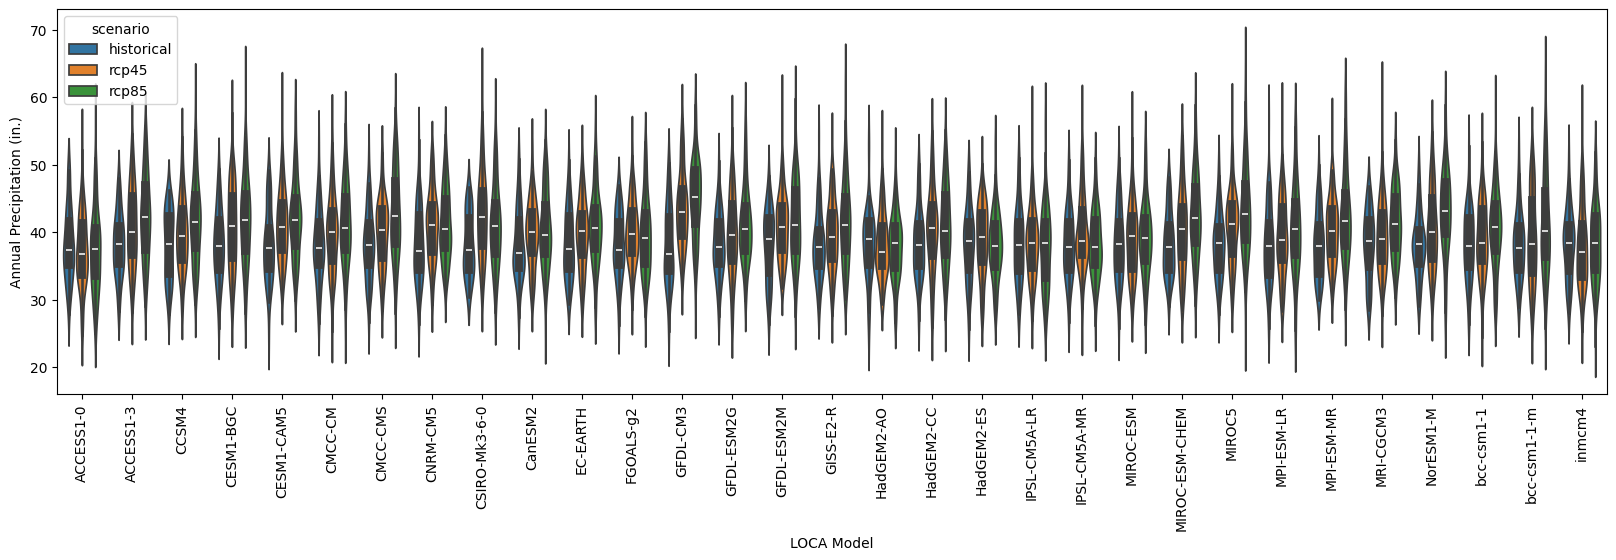

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.violinplot(data=loca_annual_totals.reset_index().melt(id_vars = ['model', 'scenario']),  x='model', y='value', hue='scenario', ax=ax)
plt.ylabel('Annual Precipitation (in.)')
plt.xlabel('LOCA Model')
plt.xticks(rotation=90)
#plt.hlines(annual_totals_obs.median(), -1, 4)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, '5-min'),
  Text(1, 0, '10-min'),
  Text(2, 0, '15-min'),
  Text(3, 0, '30-min'),
  Text(4, 0, '60-min'),
  Text(5, 0, '2-hr'),
  Text(6, 0, '3-hr'),
  Text(7, 0, '6-hr'),
  Text(8, 0, '12-hr'),
  Text(9, 0, '24-hr'),
  Text(10, 0, '2-day'),
  Text(11, 0, '3-day'),
  Text(12, 0, '4-day'),
  Text(13, 0, '7-day'),
  Text(14, 0, '10-day'),
  Text(15, 0, '20-day'),
  Text(16, 0, '30-day'),
  Text(17, 0, '45-day'),
  Text(18, 0, '60-day')])

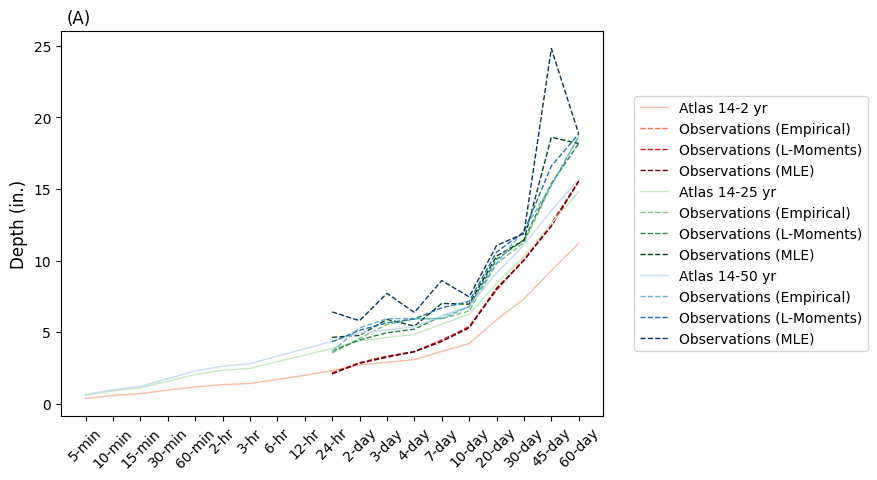

In [ ]:
# Create a new figure with a specified size (14 inches wide, 8 inches tall)
fig, ax = plt.subplots(figsize=(7,5))

cmaps_list = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues]
j=0
for return_periodOI in [2, 25, 50]:
  colormap = cmaps_list[j]
  num_return_periods = 5
  color_list = [colormap(i) for i in np.linspace(0, 1, num_return_periods)] # Create a list of colors from the colormap

  plt.plot(atlas14[[str(return_periodOI)]],lw=1,ls='-',color=color_list[1],label=f'Atlas 14-{return_periodOI} yr')
  plt.plot(obs_thresholds_empirical[[return_periodOI]],lw=1,ls='--', color=color_list[2], label='Observations (Empirical)')
  plt.plot(obs_thresholds_lmom[[return_periodOI]],lw=1,ls='--',color=color_list[3],label='Observations (L-Moments)')
  plt.plot(obs_thresholds_mle[[return_periodOI]],lw=1,ls='--',color=color_list[4],label='Observations (MLE)')

  j=j+1
# Set x-axis tick labels to match durations
plt.ylabel('Depth (in.)',fontsize=12)
#plt.title(f'{return_periodOI}-yr Return Period',fontsize=15)
plt.legend(loc = 'center right', bbox_to_anchor=(1.5, 0.5))
plt.text(0.01, 1.02, "(A)",transform=ax.transAxes,fontsize=12)
plt.xticks(rotation=45)

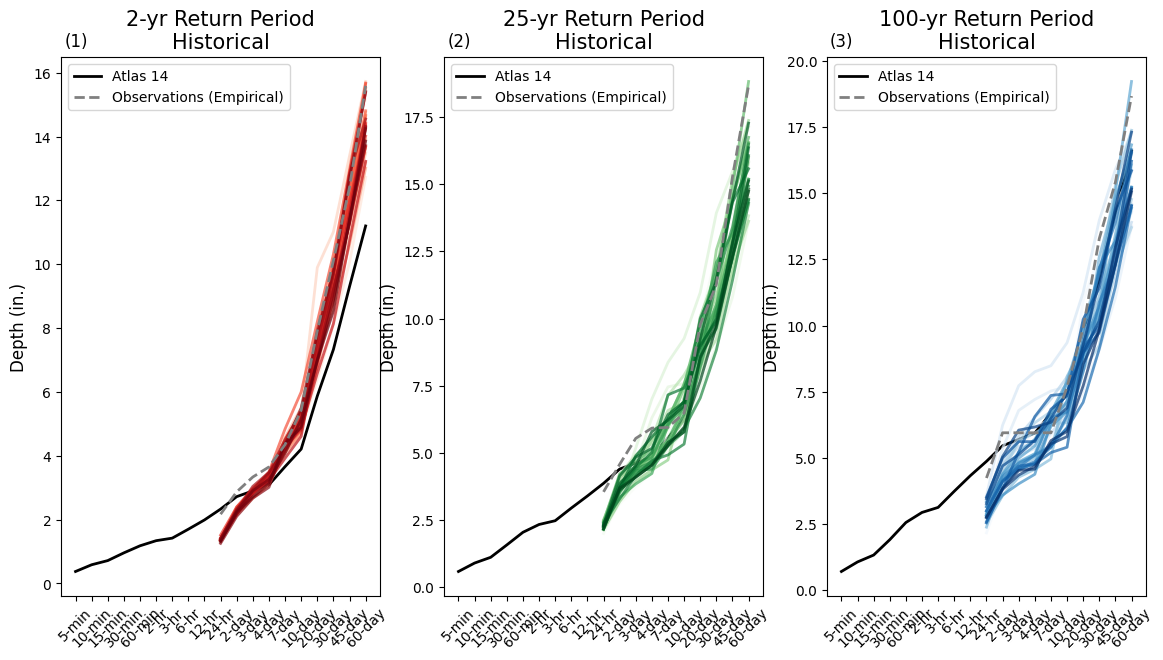

In [ ]:
# Create a new figure
fig, axs = plt.subplots(1,3,figsize=(14,7))

cmaps_list = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues]
j=0
for return_periodOI in [2, 25, 100]:
  ax = axs[j]
  i=0
  colormap = cmaps_list[j]
  num_return_periods = len(models) # Number of colors needed
  color_list = [colormap(i) for i in np.linspace(0, 1, num_return_periods)] # Create a list of colors from the colormap
  # Plot NOAA Atlas 14 IDF curve (black solid line)
  ax.plot(atlas14[[str(return_periodOI)]],lw=2,ls='-',color='k',label='Atlas 14')

  # Plot LOCA2-derived IDF curve (orange dotted line)
  #for model in models_loca2:
  for model in models:
    means = pd.DataFrame.from_dict(loca_thresholds_cp, orient='index').stack()['historical'][model]
    ax.plot(means[return_periodOI],lw=2, ls='-', color=color_list[i], alpha = 0.7, label = '_nolabel')
    i=i+1

  ax.plot(obs_thresholds_empirical[[return_periodOI]],lw=2,ls='--',color='gray',label='Observations (Empirical)')
  j=j+1

  # Set x-axis tick labels to match durations
  ax.set_ylabel('Depth (in.)',fontsize=12)
  ax.set_title(f'{return_periodOI}-yr Return Period\nHistorical',fontsize=15)
  ax.text(0.01, 1.02, f"({j})",transform=ax.transAxes,fontsize=12)
  plt.setp(ax.get_xticklabels(), rotation=45)
  ax.legend()


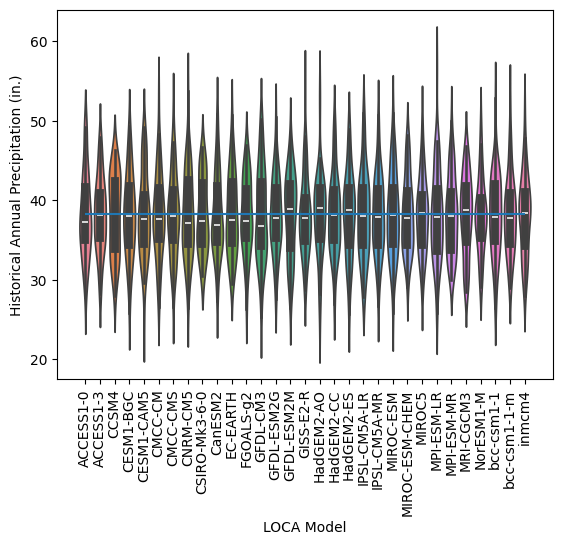

In [ ]:
import seaborn as sns
data = pd.DataFrame(annual_totals, index = models)
sns.violinplot(data=data.T)
plt.ylabel('Historical Annual Precipitation (in.)')
plt.xlabel('LOCA Model')
plt.xticks(rotation=90)
plt.hlines(annual_totals_obs.median(), 0, len(models)-1)

## LOCA2

In [ ]:
loca2_directory = "https://cirrus.ucsd.edu/~pierce/LOCA2/CONUS_regions_split"
# List of 21 climate models used in the LOCA2 dataset
models_loca2 = [
    "ACCESS-CM2", "ACCESS-ESM1-5", "AWI-CM-1-1-MR", "BCC-CSM2-MR", "CanESM5",
    "CNRM-CM6-1", "CNRM-ESM2-1", "EC-Earth3-Veg", "EC-Earth3", "FGOALS-g3",
    "GFDL-ESM4", "INM-CM4-8", "INM-CM5-0", "IPSL-CM6A-LR", "KACE-1-0-G",
    "MIROC6", "MPI-ESM1-2-HR", "MPI-ESM1-2-LR", "MRI-ESM2-0",
    "NorESM2-LM", "NorESM2-MM"
]
region = "n_east"

for model in models_loca2[:4]:
  directory = f"{loca2_directory}/{model}/{region}/0p0625deg"
  #Accept (-A) only precipitation (pr) directories
  !wget -r -nc -np -A "pr*n_east.nc" -nH --cut-dirs=3 -R "index.html*" {directory}

Streaming output truncated to the last 5000 lines.

AWI-CM-1-1-MR/n_eas 100%[===================>]   1.69K  --.-KB/s    in 0s      

2025-05-03 02:59:47 (309 MB/s) - ‘AWI-CM-1-1-MR/n_east/0p0625deg/r1i1p1f1/index.html.tmp’ saved [1728/1728]

Removing AWI-CM-1-1-MR/n_east/0p0625deg/r1i1p1f1/index.html.tmp since it should be rejected.

--2025-05-03 02:59:47--  https://cirrus.ucsd.edu/~pierce/LOCA2/CONUS_regions_split/AWI-CM-1-1-MR/n_east/0p0625deg/r2i1p1f1/
Reusing existing connection to cirrus.ucsd.edu:443.
HTTP request sent, awaiting response... 200 OK
Length: 1340 (1.3K) [text/html]
Saving to: ‘AWI-CM-1-1-MR/n_east/0p0625deg/r2i1p1f1/index.html.tmp’

AWI-CM-1-1-MR/n_eas 100%[===================>]   1.31K  --.-KB/s    in 0s      

2025-05-03 02:59:47 (259 MB/s) - ‘AWI-CM-1-1-MR/n_east/0p0625deg/r2i1p1f1/index.html.tmp’ saved [1340/1340]

Removing AWI-CM-1-1-MR/n_east/0p0625deg/r2i1p1f1/index.html.tmp since it should be rejected.

--2025-05-03 02:59:47--  https://cirrus.ucsd.edu/~pierce

In [ ]:
loca2_thresholds_cp = {}
loca2_cp_idf = {}
loca2_change_factor = {}
j=0

models_loca2 = [
    "ACCESS-CM2", "ACCESS-ESM1-5", "AWI-CM-1-1-MR", "BCC-CSM2-MR", "CanESM5",
    "CNRM-CM6-1", "CNRM-ESM2-1", "EC-Earth3-Veg", "EC-Earth3", "FGOALS-g3",
    "GFDL-ESM4", "INM-CM4-8", "INM-CM5-0", "IPSL-CM6A-LR", "KACE-1-0-G",
    "MIROC6", "MPI-ESM1-2-HR", "MPI-ESM1-2-LR", "MRI-ESM2-0",
    "NorESM2-LM", "NorESM2-MM"
]

scenarios_loca2 = ['historical', 'ssp245', 'ssp370', 'ssp585']

index_levels = [models_loca2[:4], scenarios_loca2]  # Replace with your actual model and scenario values
index_names = ['model', 'scenario']

multi_index = pd.MultiIndex.from_product(index_levels, names=index_names)
loca2_annual_totals = pd.DataFrame(index=multi_index, columns=range(100))

for scen in scenarios_loca2:
  loca2_thresholds_cp[scen]={}
  loca2_change_factor[scen]={}
  loca2_cp_idf[scen]={}

  i=0
  for model in models_loca2:
    loca2_thresholds_cp[scen][model] = np.empty([1,6])
    #Open the dataset for each scenario
    if scen == 'historical':
      ds = xr.open_dataset(glob.glob(f"/content/{model}/n_east/0p0625deg/r1i1p1f1/{scen}/pr/pr.{model}.{scen}.r1i1p1f1.*.LOCA_16thdeg_v20240915.n_east.nc")[0])
      precip = processDS_Precip(ds, locs[0])
    else: #Load different future time periods from each model
      ds1 = xr.open_dataset(glob.glob(f"/content/{model}/n_east/0p0625deg/r1i1p1f1/{scen}/pr/pr.{model}.{scen}.r1i1p1f1.2015-2044.LOCA_16thdeg_v20240915.n_east.nc")[0])
      ds2 = xr.open_dataset(glob.glob(f"/content/{model}/n_east/0p0625deg/r1i1p1f1/{scen}/pr/pr.{model}.{scen}.r1i1p1f1.2045-2074.LOCA_16thdeg_v20240915.n_east.nc")[0])
      ds3 = xr.open_dataset(glob.glob(f"/content/{model}/n_east/0p0625deg/r1i1p1f1/{scen}/pr/pr.{model}.{scen}.r1i1p1f1.2075-2100.LOCA_16thdeg_v20240915.n_east.nc")[0])
      precip1 = processDS_Precip(ds1, locs[0])
      precip2 = processDS_Precip(ds2, locs[0])
      precip3 = processDS_Precip(ds3, locs[0])
      precip = np.concatenate((precip1, precip2, precip3), axis=0)

    #Log annual precipitation for each model, i, and each scenario, j
    annual_temp = annual_totals(precip)
    loca2_annual_totals.loc[(model, scen), :] = np.pad(annual_temp, (0, 100-len(annual_temp)), 'constant', constant_values=np.nan)
    #Log empirical thresholds
    loca2_thresholds_cp[scen][model] = calc_rp_values(precip)
    # Log Change Factors
    loca2_change_factor[scen][model] = loca2_thresholds_cp[scen][model]/loca2_thresholds_cp['historical'][model]
    # Log Adjusted Atlas14 Curve
    loca2_cp_idf[scen][model] = atlas14[['2', '5', '10', '25', '50', '100']]*np.nanmean(loca2_change_factor[scen][model],axis=0)
    i=i+1
  j=j+1

with open('/content/drive/MyDrive/Research/MARISA_IDF/data/loca2_annual_totals.pkl', 'wb') as f:
    pickle.dump(loca2_annual_totals, f)
with open('/content/drive/MyDrive/Research/MARISA_IDF/data/loca2_thresholds_cp.pkl', 'wb') as f:
    pickle.dump(loca2_thresholds_cp, f)
with open('/content/drive/MyDrive/Research/MARISA_IDF/data/loca2_change_factor.pkl', 'wb') as f:
    pickle.dump(loca2_change_factor, f)
with open('/content/drive/MyDrive/Research/MARISA_IDF/data/loca2_cp_idf.pkl', 'wb') as f:
    pickle.dump(loca2_cp_idf, f)


IndexError: list index out of range

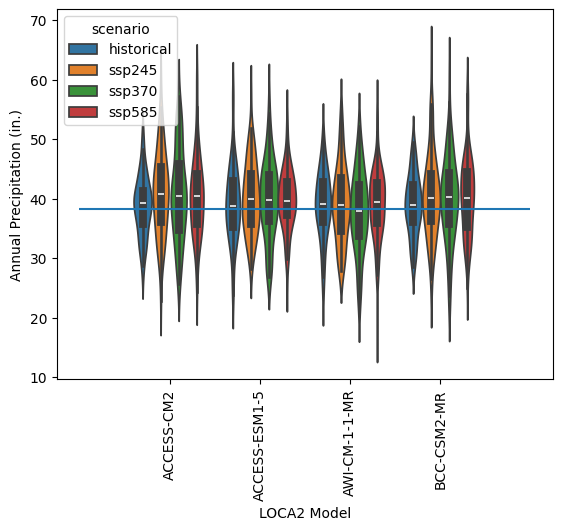

In [ ]:
sns.violinplot(data=loca2_annual_totals.reset_index().melt(id_vars = ['model', 'scenario']),  x='model', y='value', hue='scenario')
plt.ylabel('Annual Precipitation (in.)')
plt.xlabel('LOCA2 Model')
plt.xticks(rotation=90)
plt.hlines(annual_totals_obs.median(), -1, 4)

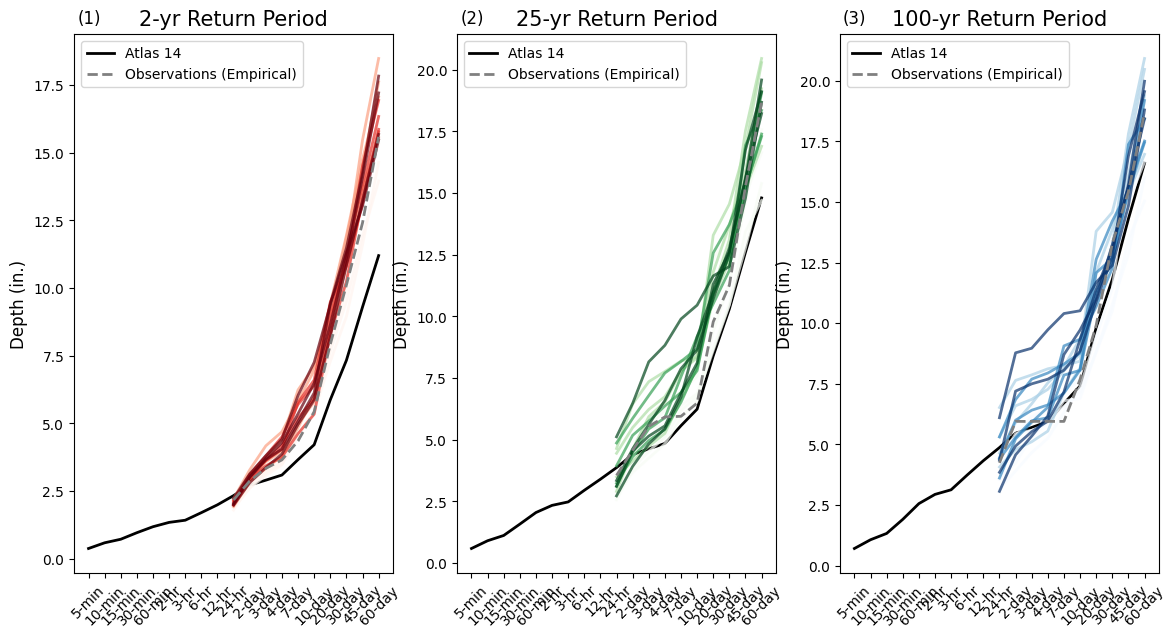

In [ ]:
# Create a new figure
fig, axs = plt.subplots(1,3,figsize=(14,7))

cmaps_list = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues]
j=0
for return_periodOI in [2, 25, 100]:
  ax = axs[j]
  i=0
  colormap = cmaps_list[j]
  num_return_periods = len(models_loca2[:4]) # Number of colors needed
  color_list = [colormap(i) for i in np.linspace(0, 1, num_return_periods)] # Create a list of colors from the colormap
  # Plot NOAA Atlas 14 IDF curve (black solid line)
  ax.plot(atlas14[[str(return_periodOI)]],lw=2,ls='-',color='k',label='Atlas 14')

  for scen in ['historical', 'ssp245', 'ssp370', 'ssp585']:
    for model in models_loca2[:4]:
      means = pd.DataFrame.from_dict(loca2_thresholds_cp, orient='index').stack()[scen][model]
      ax.plot(means[return_periodOI],lw=2, ls='-', color=color_list[i], alpha = 0.7, label = '_nolabel')

    i=i+1

  ax.plot(obs_thresholds_empirical[[return_periodOI]],lw=2,ls='--',color='gray',label='Observations (Empirical)')
  j=j+1

  # Set x-axis tick labels to match durations
  ax.set_ylabel('Depth (in.)',fontsize=12)
  ax.set_title(f'{return_periodOI}-yr Return Period',fontsize=15)
  ax.text(0.01, 1.02, f"({j})",transform=ax.transAxes,fontsize=12)
  plt.setp(ax.get_xticklabels(), rotation=45)
  ax.legend()

In [ ]:
annual_totals = np.empty((len(models), 56))
for i in range(len(models)):
  daily_data = pd.Series(precip_record[i, 0, :], index=pd.date_range('1950-01-01', periods=len(precip_record[i, 0, :])))

  # Calculate monthly totals
  annual_totals[i,:] = daily_data.resample('Y').sum()

In [ ]:
annual_totals = precip_obs['PRCP'].values

In [ ]:
model_mean = pd.DataFrame.from_dict(loca2_cp_idf, orient='index').stack().reset_index().groupby('level_0')[0].agg(array_mean)

## Comparison of Historical Empirical Curves

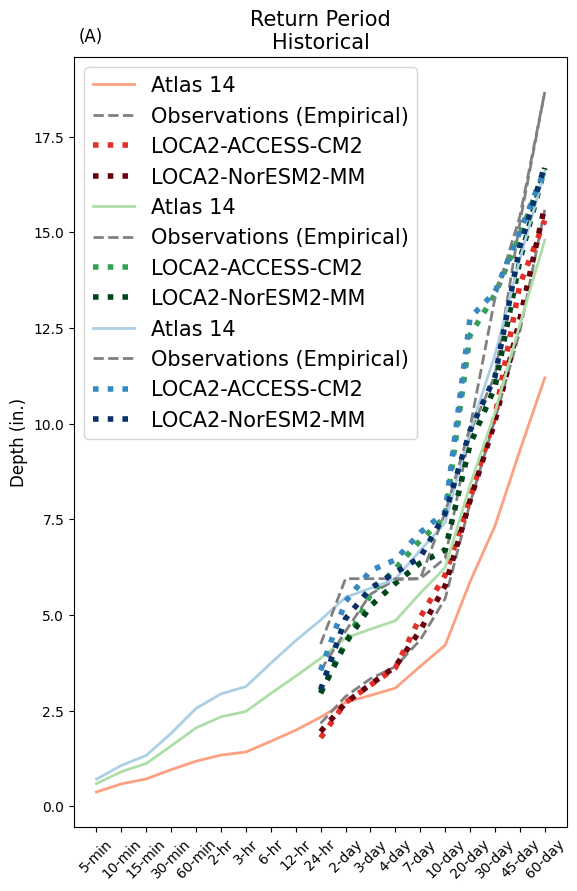

In [ ]:
# Create a new figure with a specified size (14 inches wide, 8 inches tall)
fig = plt.figure(figsize=(14,10))
# Add first subplot (1 row, 2 columns, 1st position)
ax = fig.add_subplot(121)

cmaps_list = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues]
j=0
for return_periodOI in [2, 25, 100]:
  i=1
  colormap = cmaps_list[j]
  num_return_periods = 4 # Number of return periods you have
  color_list = [colormap(i) for i in np.linspace(0, 1, num_return_periods)] # Create a list of colors from the colormap

  # Plot NOAA Atlas 14 IDF curve (black solid line)
  plt.plot(atlas14[[str(return_periodOI)]],lw=2,ls='-',color=color_list[i],label='Atlas 14')
  plt.plot(obs_thresholds[[return_periodOI]],lw=2,ls='--',color='gray',label='Observations (Empirical)')

  # Plot LOCA2-derived IDF curve (orange dotted line)
  #for model in models_loca2:
  for model in ['ACCESS-CM2', 'NorESM2-MM']:
    i=i+1
    means = pd.DataFrame.from_dict(thresholds_cp, orient='index').stack()['historical'][model]
    plt.plot(means[return_periodOI],lw=4,label=f'LOCA2-{model}',ls=':', color=color_list[i])
  j=j+1

# Set x-axis tick labels to match durations
plt.ylabel('Depth (in.)',fontsize=12)
plt.title(f'Return Period\nHistorical',fontsize=15)
plt.text(0.01, 1.02, "(A)",transform=ax.transAxes,fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=15)

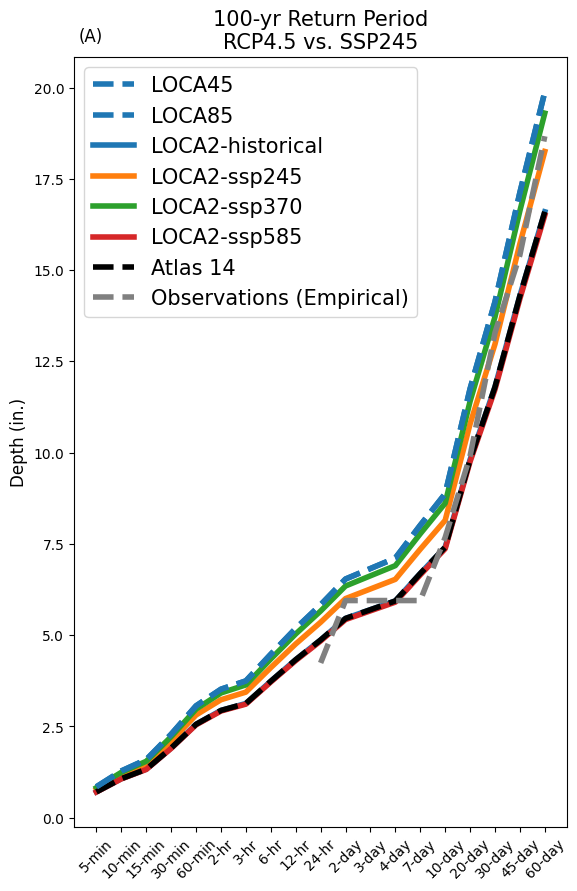

In [ ]:
# Create a new figure with a specified size (14 inches wide, 8 inches tall)
fig = plt.figure(figsize=(14,10))
# Add first subplot (1 row, 2 columns, 1st position)
ax = fig.add_subplot(121)
# Plot NOAA Atlas 14 IDF curve (black solid line)

return_periodOI = 100

# Plot LOCA-derived IDF curve (blue dashed line)
plt.plot(loca_cp_idf_rcp45[str(return_periodOI)],lw=4,label='LOCA45',color="tab:blue",ls='--',zorder=10)
plt.plot(loca_cp_idf_rcp85[str(return_periodOI)],lw=4,label='LOCA85',color="tab:blue",ls='--',zorder=10)
# Plot LOCA2-derived IDF curve (orange dotted line)
for scen in ['historical', 'ssp245', 'ssp370', 'ssp585']:
  means = pd.DataFrame(model_mean[scen], columns=['2', '5', '10', '25', '50', '100'], index = ['5-min', '10-min', '15-min', '30-min', '60-min', '2-hr', '3-hr', '6-hr',
       '12-hr', '24-hr', '2-day', '3-day', '4-day', '7-day', '10-day',
       '20-day', '30-day', '45-day', '60-day'])
  plt.plot(means[str(return_periodOI)],lw=4,label=f'LOCA2-{scen}',ls='solid')

plt.plot(atlas14[[str(return_periodOI)]],lw=4,ls='--',color='k',label='Atlas 14')
plt.plot(obs_thresholds[[return_periodOI]],lw=4,ls='--',color='gray',label='Observations (Empirical)')
# Set x-axis tick labels to match durations
plt.ylabel('Depth (in.)',fontsize=12)
plt.title(f'{return_periodOI}-yr Return Period\nRCP4.5 vs. SSP245',fontsize=15)
plt.text(0.01, 1.02, "(A)",transform=ax.transAxes,fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=15)